# Linear Regression and Submission for [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting)
---
### Summary

[**1. Load, Merge and Clean the Dataset**](#1.-Load,-Merge-and-Clean-the-Dataset)

[**2. Feature Engineering**](#2.-Feature-Engineering)
- 2.1 Feature Creation: convert `'visit_date'` into numeric variables
- 2.2 Feature Creation: cluster restaurants based on activity
- 2.3 Feature Creation: cluster restaurants based on geographical coordinates
- 2.4 Feature Creation: convert restaurant ID's into numeric variables
- 2.5 Update `'visitors'` with the average daily visitors
- 2.6 Update missing `'reservations'`
- 2.7 Feature Selection: check correlation between `short_df` features
- 2.8 Feature Selection (Univariate): evaluate features based on the level of association with its target
- 2.9 Feature Selection (Univariate): choose features based on their effective contribution

[**3. Linear Regression**](#3.-Linear-Regression)
- 3.1 Cross-validation
- 3.2 Split data into train & test
- 3.3 Test and Evaluation 

[**4. Regularized Regression**](#4.-Regularized-Regression)
- 4.1 Ridge
- 4.2 Lasso

[**5. Kaggle Submission**](#5.-Submission)

---

# 1. Load, Merge and Clean the Dataset

In [1]:
# load all datasets, then merge and clean them to be used:
from lib import clean_db

df = clean_db.load_from('data')                 # 'data': directory that contains .csv files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

df.visit_date = pd.to_datetime(df.visit_date)   # Convert column visit_date to Datetime object

A Jupyter Widget

# 2. Feature Engineering

First, check the correlation between *original* `df` features:

>>> There are 829 different restaurants.
>>> df shape= (255917, 10)


,air_store_id,visit_date,visitors,genre_name,area_name,latitude,longitude,reservations,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,-1.0,Friday,0


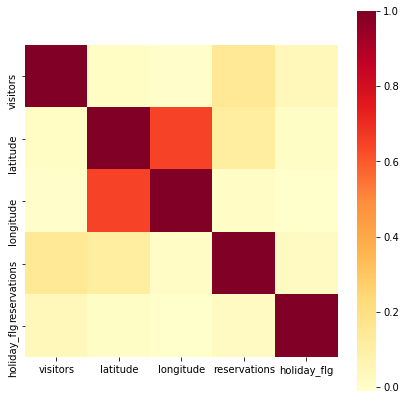

In [2]:
print('>>> There are', len(df.air_store_id.unique()), 'different restaurants.')
print('>>> df shape=', df.shape)
display(df.head(3))

# Plot correlation between different features
plt.figure(figsize=(7, 7))
sns.heatmap(df.corr(), square=True, cmap='YlOrRd') # RdBu_r, YlOrRd
plt.plot()
plt.show()

### 2.1 Feature Creation: convert `'visit_date'` into numeric variables

`short_df` is the resulting DataFrame, created to store all the features used for linear regression later on. 

In [3]:
# Select which features are going to be used from the Dataframe
def get_features_df():
    short_df = df[ ['air_store_id', 'visit_date', 'visitors', 'day_of_week', 'holiday_flg', 'reservations'] ].copy()

    short_df['year'] = df['visit_date'].dt.year
    short_df['month'] = df['visit_date'].dt.month
    short_df['day'] = df['visit_date'].dt.day

    # Convert 'day_of_week' categorical feature into dummy variable
    short_df = pd.get_dummies(short_df, columns=['day_of_week'])
    
    return short_df


short_df = get_features_df()
print('>>> short_df shape=', short_df.shape)
display(short_df.head(3))

>>> short_df shape= (255917, 15)


,air_store_id,visit_date,visitors,holiday_flg,reservations,year,month,day,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,air_ba937bf13d40fb24,2016-01-13,25,0,-1.0,2016,1,13,0,0,0,0,0,0,1
1,air_ba937bf13d40fb24,2016-01-14,32,0,-1.0,2016,1,14,0,0,0,0,1,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,0,-1.0,2016,1,15,1,0,0,0,0,0,0


### 2.2 Feature Creation: cluster restaurants based on activity

In [4]:
def get_restaurant_matrix():
    short_df = get_features_df()
    matrix_df = short_df.drop('visit_date', axis=1).pivot_table(index=['air_store_id'], columns=['day','month','year','holiday_flg'], values='visitors')
    matrix_df.fillna(0, inplace=True)
    return matrix_df

display(get_restaurant_matrix().head(3))

day                    1                                                      \
month                  1         2          3           4           5     6    
year                 2016 2017 2016  2017 2016  2017  2016  2017  2016  2016   
holiday_flg             1    1    0     0    0     0     0     0     0     0   
air_store_id                                                                   
air_00a91d42b08b08d9  0.0  0.0  0.0  27.0  0.0  17.0   0.0   7.0   0.0   0.0   
air_0164b9927d20bcc3  0.0  0.0  0.0  12.0  0.0  24.0   0.0  11.0   0.0   0.0   
air_0241aa3964b7f861  0.0  0.0  6.0  12.0  1.0  13.0  12.0   7.0  10.0  10.0   

day                  ...     30    31                                          \
month                ...     12    1          3           5    7     8     10   
year                 ...   2016  2016  2017 2016  2017  2016 2016  2016  2016   
holiday_flg          ...      1     0     0    0     0     0    0     0     0   
air_store_id         ...                                                        
air_00a91d42b08b08d9 ...    0.0   0.0  28.0  0.0  38.0   0.0  0.0  36.0  26.0   
air_0164b9927d20bcc3 ...   21.0   0.0  18.0  0.0   4.0   0.0  0.0   0.0   9.0   
air_0241aa3964b7f861 ...    0.0  11.0   0.0  0.0  10.0  17.0  3.0   9.0   4.0   

day                        
month                  12  
year                 2016  
holiday_flg             1  
air_store_id               
air_00a91d42b08b08d9  0.0  
air_0164b9927d20bcc3  0.0  
air_0241aa3964b7f861  6.0  

[3 rows x 478 columns]

In [5]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

### Plot Elbow SS Number for choosing the number of clusters
def plot_elbow_analisys(df, k_range):    
    ess_scores_vec = [] # vector with one elbow ss score per cluster
    for k in k_range:
        model = KMeans(n_clusters=k)    
        model.fit(df)

        # compute Elbow SS Method
        ss = sum(np.min(cdist(df, model.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0]        
        ess_scores_vec.append(ss)   
        
    return ess_scores_vec  
    

### Plot Silhouette Analisys for choosing the number of clusters    
def plot_silhouette_analisys(df, k_range): 
    s_scores_vec = []
    for k in k_range:
        model = KMeans(n_clusters=k)       
        labels = model.fit_predict(df)

        # compute silhouette score for ALL samples
        s_score_avg = silhouette_score(df, labels)
        s_scores_vec.append(s_score_avg)     
        
    return s_scores_vec

In [6]:
# Execute SS Elbow and Silhouette methods, for all clusters in the range(2, 12)
k_range = range(2, 13)
matrix_df = get_restaurant_matrix()

ess_scores_vec = plot_elbow_analisys(matrix_df, k_range)
s_scores_vec = plot_silhouette_analisys(matrix_df, k_range)

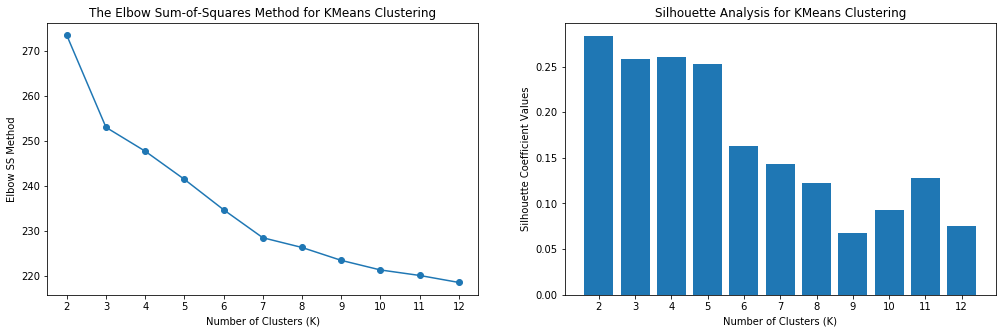

In [7]:
### Plot SS Elbow results to the left and Silhouette analysis to the right
fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Elbow Analisys Plot: clusters vs inertias
ax1.plot(k_range, ess_scores_vec, '-o')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Elbow SS Method')
ax1.set_xticks(k_range)
ax1.set_title('The Elbow Sum-of-Squares Method for KMeans Clustering')

# Silhouette Analisys Plot: coefficients vs clusters
ax2.bar(list(k_range), s_scores_vec)   
ax2.set_xticks(list(k_range))
ax2.set_xticklabels(list(k_range))
ax2.set_xlabel("Number of Clusters (K)")
ax2.set_ylabel("Silhouette Coefficient Values")
ax2.set_title('Silhouette Analysis for KMeans Clustering')

plt.show()

In [8]:
# Define the number of clusters (restaurants)
N = 2

#display(matrix_df.head())

>>> Agglomerative Clustering silhouette coef: 0.238824674064


,air_store_id,cluster_id,x,y
0,air_00a91d42b08b08d9,0,-31.442905,77.352643
1,air_0164b9927d20bcc3,1,-242.653670,-46.646770
2,air_0241aa3964b7f861,1,-126.598772,-115.391197


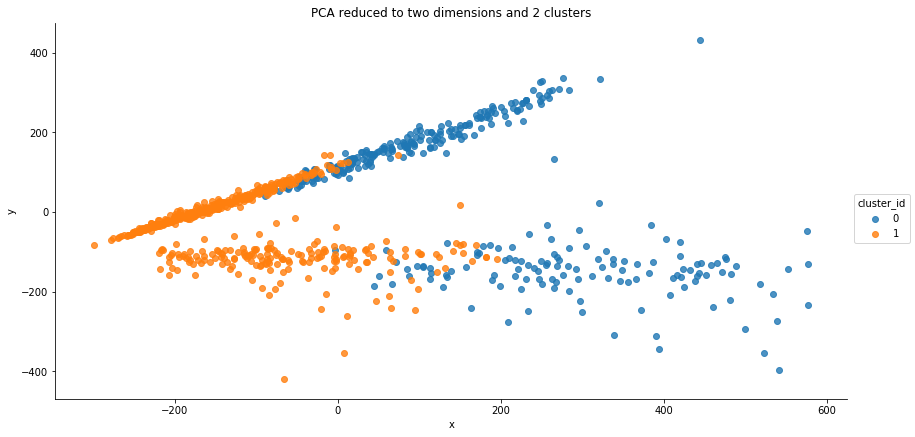

In [9]:
### Visualize clusters
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

matrix_df = get_restaurant_matrix()

# Compute KMeans Clustering
# model = KMeans(n_clusters=N)       
# labels = model.fit_predict(matrix_df)
# print('>>> KMeans Clustering silhouette coef:', silhouette_score(matrix_df, labels))            # score: 0.247566398619

# Compute Agglomerative Clustering
model = AgglomerativeClustering(n_clusters=N, linkage='ward')
model.fit(matrix_df)
labels = model.labels_
print('>>> Agglomerative Clustering silhouette coef:', silhouette_score(matrix_df, labels))     # score: 0.107796894178

# Compute Spectral Clustering
# model = SpectralClustering(n_clusters=N)
# model.fit(matrix_df)
# labels = model.labels_
# print('>>> Spectral Clustering silhouette coef:', silhouette_score(matrix_df, labels))          # score: -0.0180766974492

# reduce the dimensionality of clustering data to 2 components
pca = PCA(n_components=2)
pca.fit(matrix_df)
pca_features = pca.transform(matrix_df)

# create output df
cluster_df = pd.DataFrame()
cluster_df['air_store_id'] = matrix_df.index
cluster_df['cluster_id'] = labels
cluster_df['x'] = pca_features[:,0]
cluster_df['y'] = pca_features[:,1]

display(cluster_df.head(3))

# Draw scatter plot
sns.lmplot(data=cluster_df, x='x', y='y', hue='cluster_id', fit_reg=False, legend=True, size=6, aspect=2)
ax = plt.gca()
ax.set_title('PCA reduced to two dimensions and ' + str(N) + ' clusters')
plt.show()

In [10]:
# Add a cluster_id for every restaurant
short_df = pd.merge(short_df, cluster_df[['air_store_id', 'cluster_id']], on='air_store_id', how='left')
#display(short_df[short_df['cluster_id'] == 2].tail())

### 2.3 Feature Creation: cluster restaurants based on geographical coordinates

**Do not use this!** This feature was removed since no cluster size improved the Kaggle score (at all).

### 2.4 Feature Creation: convert restaurant ID's into numeric variables

**Do not use this!** Since RFECV dismissed `'air_store_id'` as an encoded variable, we are not using it.

In [11]:
# Convert 'air_store_id' categorical feature into an encoded variable
# from sklearn.preprocessing import LabelEncoder
# label_enc = LabelEncoder()
# label_enc.fit(short_df['air_store_id'])
# short_df['air_store_id_enc'] = label_enc.transform(short_df['air_store_id'])  # transform categories into integers

### 2.5 Feature Creation: average daily visitors

**Do not use this!** Kaggle Score after this change dropped from 0.723 to 0.763.

In [12]:
# short_df.visit_date = pd.to_datetime(short_df.visit_date)
# tmp_df = short_df.set_index(short_df.visit_date)
# daily_visits_df = tmp_df.resample('D').median().reset_index()[['visit_date', 'visitors']]
# daily_visits_df.rename(columns={'visitors': 'avg_daily_visits'}, inplace=True)

# print('>>> Daily visitors:')
# display(daily_visits_df.tail())

# # Copy 'avg_visitors' to short_df
# short_df = pd.merge(short_df, daily_visits_df, on='visit_date', how='left')  
# display(short_df.tail())

### 2.6 Update missing `'reservations'`

A lot of reservation values are missing (-1). Given that this variable has a lot on influence in our model, can we predict some reservation data just by looking into other features (visit_date/visitors/geographical coord)?

In [13]:
# TODO

### 2.7 Feature Selection: check correlation between `short_df` features

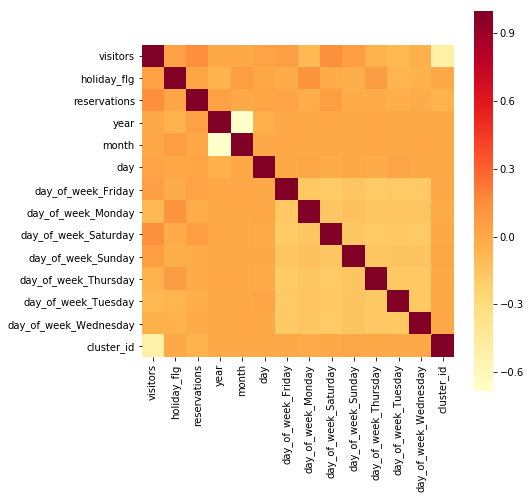

In [14]:
# Plot correlation between different features
plt.figure(figsize=(7, 7))
sns.heatmap(short_df.corr(), square=True, cmap='YlOrRd')  # RdBu_r, YlOrRd
plt.plot()
plt.show()

Generate the list of features used for linear regression:

In [15]:
# get_features(): returns a list of all column names used as features
def get_features():
    feature_names = short_df.columns.values.tolist()
    feature_names.remove('visitors')
    feature_names.remove('visit_date')
    feature_names.remove('air_store_id')    
    return feature_names

print('>>> Features =\n', get_features())

>>> Features =
 ['holiday_flg', 'reservations', 'year', 'month', 'day', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'cluster_id']


### 2.8 Feature Selection (Univariate): evaluate features based on the level of association with its target

`SelectPercentile()` provides an automatic procedure for keeping only a certain percentage of the best, associated features. The main metrics for association for regression purposes is `f_regression`, used only for numeric targets.

Apart from applying a direct selection of the top percentile associations, SelectPercentile can also rank the best variables to make it easier to decide at what percentile to exclude a feature from participating in the learning process. 

Using the level of association output helps you to choose the most important variables for your machine-learning model, but you should watch out for these possible problems:

- Some variables with high association could also be highly correlated, introducing duplicated information, which acts as noise in the learning process.
- Some variables may be penalized, especially binary ones (variables indicating a status or characteristic using the value 1 when it is present, 0 when it is not). 

The higher the F-score, the more associated with the target variable that feature is.

In [16]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression

feature_names = get_features()
X = short_df[feature_names]
y = short_df.visitors

selector_f = SelectPercentile(f_regression, percentile=25)
selector_f.fit(X,y)

zipped_list = zip(feature_names, selector_f.scores_)
zipped_list = sorted(zipped_list, key=lambda x: x[1])

# Print most important features first:
for feature, score in reversed(zipped_list):
    print('>>> F-score: %3.2f \tfor feature %s ' % (score, feature))

>>> F-score: 88741.00 	for feature cluster_id 
>>> F-score: 5564.14 	for feature reservations 
>>> F-score: 5320.88 	for feature day_of_week_Saturday 
>>> F-score: 2008.97 	for feature day_of_week_Monday 
>>> F-score: 1778.92 	for feature day_of_week_Tuesday 
>>> F-score: 938.31 	for feature day_of_week_Sunday 
>>> F-score: 839.61 	for feature day_of_week_Friday 
>>> F-score: 703.73 	for feature day_of_week_Thursday 
>>> F-score: 526.54 	for feature day_of_week_Wednesday 
>>> F-score: 443.92 	for feature holiday_flg 
>>> F-score: 187.03 	for feature day 
>>> F-score: 2.47 	for feature month 
>>> F-score: 0.32 	for feature year 


### 2.9 Feature Selection (Univariate): choose features based on their effective contribution

Automatically reduce the number of features involved in a learning model on the basis of their effective contribution to the performance measured by the error measure.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from itertools import compress

reg = LinearRegression() 
selector = RFECV(estimator=reg, cv=5, scoring='neg_mean_squared_error')
selector.fit(X, y)

print('>>> Optimal number of features: %d' % selector.n_features_)
print('\n>>> Features:\n', feature_names)
print('\n>>> Optimal Features:\n', list(compress(feature_names, selector.support_)))

>>> Optimal number of features: 13

>>> Features:
 ['holiday_flg', 'reservations', 'year', 'month', 'day', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'cluster_id']

>>> Optimal Features:
 ['holiday_flg', 'reservations', 'year', 'month', 'day', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'cluster_id']


As a result from the feature selection process, we should update the function `get_features()` implemented above to reflect these preferences.

# 3. Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression

feature_names = get_features()
X = short_df[feature_names]
y = short_df.visitors.values.reshape(-1, 1)

### 3.1 Cross-validation

Model performance is dependent on way the data is split and it does not represent well the model’s ability to generalize.

In [19]:
from sklearn.model_selection import cross_val_score
reg = LinearRegression() 
cv_results = cross_val_score(reg, X, y, cv=5) 
print('>>> CV results:', cv_results)
print('>>> CV mean:', np.mean(cv_results))

>>> CV results: [ 0.25939971  0.289601    0.30429534  0.32695504  0.34949056]
>>> CV mean: 0.305948330226


### 3.2 Split data into train & test

In [20]:
# Split into train set, test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

### 3.3 Test and Evaluation 

>>> Intercept    = [ 799.40742054] 
>>> Coefficients = [[  3.62761464   0.42162723  -0.3813743   -0.03928391   0.04956807
    2.32779775  -4.27893231   5.53667982   3.26495378  -2.0074317
   -3.27044742  -1.57261993 -17.24555719]]

>>> Score: 0.309121601183
>>>  RMSE: 14.0747771244


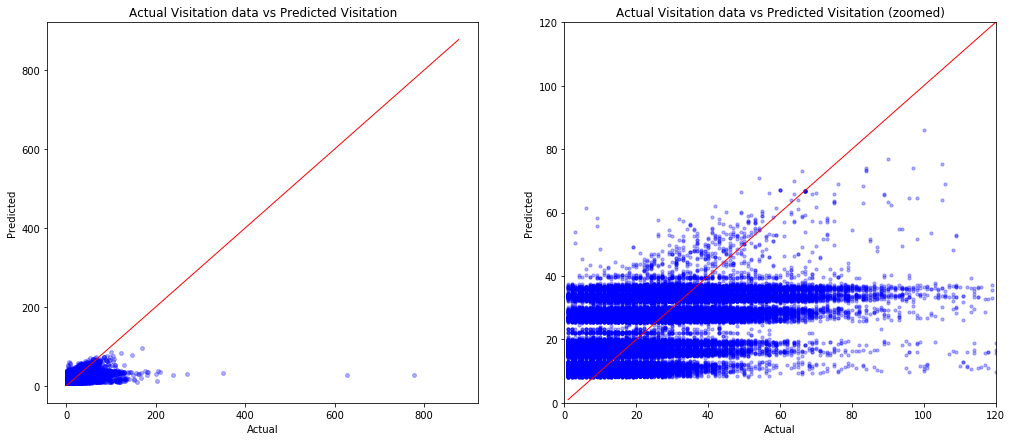

In [21]:
from sklearn import metrics

# Fit the model to the data
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('>>> Intercept    =', reg.intercept_, '\n>>> Coefficients =', reg.coef_)
print('\n>>> Score:', reg.score(X_test, y_test))                        # Score: 0.05890
print('>>>  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) # RMSE: 16.4269

### Setup plots to compare visitation data
plt.figure(figsize=(17,7))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, s=15, alpha=0.3, color='blue') 
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-', lw=1)
plt.title('Actual Visitation data vs Predicted Visitation')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, s=10, alpha=0.3, color='blue') 
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-', lw=1)
plt.title('Actual Visitation data vs Predicted Visitation (zoomed)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim(xmin=0, xmax=120)
plt.ylim(ymin=0, ymax=120)

plt.show()

# 4. Regularized Regression

Linear regression minimizes a loss function. It chooses a coeﬃcient for each feature variable. Large coeﬃcients can lead to overﬁtting. Penalizing large coeﬃcients is called *regularization*.

### 4.1 Ridge

In [22]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1, normalize=False) 
ridge.fit(X_train, y_train) 
ridge_pred = ridge.predict(X_test) 
print('\n>>> Ridge score:', ridge.score(X_test, y_test))


>>> Ridge score: 0.309121604566


### 4.2 Lasso

It shrinks coefficients of less important features to exactly 0.

>>> Lasso score: 0.306596672807


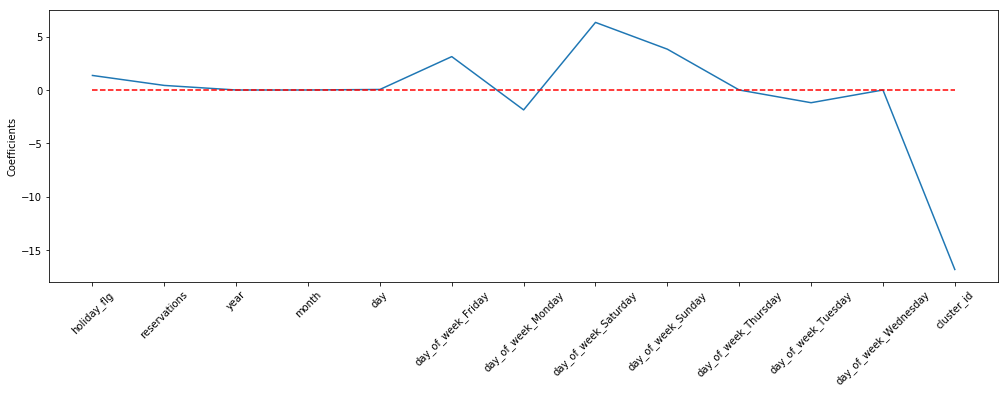

In [23]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1, normalize=False) 
model = lasso.fit(X_train, y_train) 
lasso_pred = model.predict(X_test) 
print('>>> Lasso score:', lasso.score(X_test, y_test))

# Plot lasso coefficients for feature selection
x_width = range(len(feature_names))
plt.figure(figsize=(17,5))
plt.plot(x_width, model.coef_ ) 
plt.xticks(x_width, feature_names, rotation=45) 
plt.ylabel('Coefficients') 

# plot horizontal line at Y origin
horiz_line_data = np.array([0 for i in x_width])
xs = [i for i in x_width]
plt.plot(xs, horiz_line_data, 'r--')

plt.show()

# 5. Kaggle Submission

Given that **regularized regression** didn't help to improve the model in a significant way, I decided to not use it for the time being.

In the current approach:
- `air_store_id` was encoded to be used as a feature, but this dind't improve the score at all;
- To get equivalent `holiday_flg` values for the submission dates, I retrieved the same holidays from the year before;
- `day_of_week` was encoded as a dummy variable to be used in regression;
- `reservation` data slightly improved the score, so we are using it;

All visit dates from `sample_submission.csv` are new dates. In other words, there is no visitation data in our model for the same period of time.

**Kaggle Submissions History:**
- **Score 0.723**: linear regression, Agglomerative (2 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.746**: linear regression, Agglomerative (4 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.747**: linear regression, KMeans (2 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.773**: linear regression, KMeans (4 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.794**: linear regression, KMeans (6 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.829**: linear regression, KMeans (5 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.833**: linear regression, KMeans (7 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.854**: linear regression, KMeans (8 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.859**: linear regression, KMeans (3 clusters), reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.859**: linear regression, reservations, holidays from 2016, w/o restaurant ID encoding;
- **Score 0.866**: linear regression, w/o reservations, holidays from 2016, w/o restaurant ID encoding;

In [24]:
def load_submission_file():
    sub_df = pd.read_csv('data/sample_submission.csv')    
    
    # parse store_id from: air_00a91d42b08b08d9_2017-04-23
    sub_df['air_store_id'] = sub_df.id.map(lambda x: '_'.join(x.split('_')[:-1]))  
    
    # parse date from: from: air_00a91d42b08b08d9_2017-04-23
    sub_df['visit_date'] = sub_df.id.map(lambda x: x.split('_')[2])
    
    # erase visitors column
    sub_df.drop('visitors', axis=1, inplace=True)    
    #sub_df.drop('id', axis=1, inplace=True) 
          
    return sub_df

sub_df = load_submission_file()

print('>>> sub_df, parsed sample_submission.csv:')
display(sub_df.head(3))   

print('\n>>> short_df, dataframe used for training:')
display(short_df.head(3)) 

>>> sub_df, parsed sample_submission.csv:


,id,air_store_id,visit_date
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,air_00a91d42b08b08d9,2017-04-25



>>> short_df, dataframe used for training:


,air_store_id,visit_date,visitors,holiday_flg,reservations,year,month,day,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,cluster_id
0,air_ba937bf13d40fb24,2016-01-13,25,0,-1.0,2016,1,13,0,0,0,0,0,0,1,0
1,air_ba937bf13d40fb24,2016-01-14,32,0,-1.0,2016,1,14,0,0,0,0,1,0,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,0,-1.0,2016,1,15,1,0,0,0,0,0,0,0


In [25]:
###
# 1. Load data from sample_submissions.csv
###
sub_df = load_submission_file()
print('>>> sub_df (original) shape=', sub_df.shape)

###
# 2. Prepare sub_df with all the features required for reg.predict(X):
#    holiday_flg, reservations, year, month, day, day_of_week_Friday, day_of_week_Monday, 
#    day_of_week_Saturday, day_of_week_Sunday, day_of_week_Thursday, day_of_week_Tuesday, day_of_week_Wednesday
#
# In other words, use the data from sample_submission.csv for predictions
###
# To fill the column 'holiday_flg', pretend submission's visit_date is from the previous year and copy those holidays
sub_df['visit_date'] = sub_df['visit_date'].str.replace('2017','2016')
sub_df.visit_date = pd.to_datetime(sub_df.visit_date)

# Drop duplicates in holidays_df to avoid adding more rows to the merged Dataframe
holidays_df = short_df[['visit_date', 'holiday_flg']]
holidays_df = holidays_df.drop_duplicates(subset=['visit_date'])

# Add HOLIDAY_FLG and DAY_OF_WEEK columns
sub_df = pd.merge(sub_df, holidays_df[['visit_date', 'holiday_flg']], on='visit_date', how='left')

# Add AVG_DAILY_VISITORS: copy the daily average visitation data from 2016
#sub_df = pd.merge(sub_df, daily_visits_df, on='visit_date', how='left')  

# Convert 'visit_date' to string and revert back to the original year (2017)
sub_df['visit_date'] = sub_df['visit_date'].dt.strftime('%Y-%m-%d')
sub_df['visit_date'] = sub_df['visit_date'].str.replace('2016','2017')
sub_df.visit_date = pd.to_datetime(sub_df.visit_date)
# display(sub_df.head())  

# Add 'DAY_OF_WEEK' column
import calendar
sub_df['day_of_week'] = sub_df['visit_date'].apply(lambda x: (calendar.day_name[x.weekday()]))
sub_df = pd.get_dummies(sub_df, columns=['day_of_week'])

# Add YEAR, MONTH, DAY columns
sub_df['year'] = sub_df['visit_date'].dt.year
sub_df['month'] = sub_df['visit_date'].dt.month
sub_df['day'] = sub_df['visit_date'].dt.day

# TODO: karl
### Add RESERVATIONS column: careful, there are many occurences for the same month and day
# Option #1: fill reservations with -1       
# Option #2: fill reservations with the average from that month/day. Note: ruined the score by +0.001
###
# Option #1:
sub_df['reservations'] = -1        
# Option #2: 
# tmp_df = short_df.groupby(['month', 'day']).mean().reset_index()[['month', 'day', 'reservations']]
# sub_df = pd.merge(sub_df, tmp_df, on=['month', 'day'], how='left')

# Add AIR_STORE_ID_ENC: convert categorical variable into encoded variable
#sub_df['air_store_id_enc'] = label_enc.transform(sub_df['air_store_id'])  # transform categories into integers

# Add CLUSTER_ID from the clustering process
sub_df = pd.merge(sub_df, cluster_df[['air_store_id', 'cluster_id']], on='air_store_id', how='left')

# Delete unecessary columns
del sub_df['air_store_id']
del sub_df['visit_date']

print('>>> sub_df (features) shape=', sub_df.shape)

>>> sub_df (original) shape= (32019, 3)
>>> sub_df (features) shape= (32019, 14)


In [26]:
###
# 3. Fit the model to the entire dataset and make the prediction
###
X = short_df[feature_names]
y = short_df.visitors.values.reshape(-1, 1)

reg_model = LinearRegression()
reg_model.fit(X, y)

# Make the prediction
sub_df['visitors'] = reg_model.predict(sub_df[feature_names])
print('\n>>> Features + Prediction:')
display(sub_df.head(2))  

# Filter only the columns used on the online submission page
final_df = sub_df[['id', 'visitors']]


>>> Features + Prediction:


,id,holiday_flg,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,year,month,day,reservations,cluster_id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0,0,0,0,1,0,0,0,2017,4,23,-1,0,34.000765
1,air_00a91d42b08b08d9_2017-04-24,0,0,1,0,0,0,0,0,2017,4,24,-1,0,26.467868


In [27]:
filename = 'prediction.csv'
final_df.to_csv(filename, index=False)

display(final_df.tail(5))
print('\n>>> Kaggle submission file', final_df.shape, 'saved as:', filename)

,id,visitors
32014,air_fff68b929994bfbd_2017-05-27,19.217122
32015,air_fff68b929994bfbd_2017-05-28,16.996846
32016,air_fff68b929994bfbd_2017-05-29,9.463949
32017,air_fff68b929994bfbd_2017-05-30,10.652545
32018,air_fff68b929994bfbd_2017-05-31,12.346567



>>> Kaggle submission file (32019, 2) saved as: prediction.csv
